# Bike sharing in Washington DC

LSTM (long short-term memory networks) are a variant of Recurrent neural networks (RNN) which can learn long-term dependencies, especially in sequence prediction problems. I'm going to try this model to predict the bike sharing temporal data in Whasington DC.

In [65]:
import pandas as pd
data = pd.read_csv("./data/bike-sharing.csv")

In [66]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [67]:
import tensorflow.compat.v1 as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [68]:
import pandas as pd
import numpy as np

data.shape
data.info(memory_usage="deep")

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1, color_codes=True)

data.columns
data.head()

data["datetime"] = pd.to_datetime(data["datetime"])

data = data.set_index("datetime")

data["hour"] = data.index.hour
data["day_of_month"] = data.index.day
data["day_of_week"]  = data.index.dayofweek
data["month"] = data.index.month

data.columns
data.shape

corr_matrix = data.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 2.7 MB


In [69]:
print(high_corr_var)

[('season', 'month'), ('temp', 'atemp'), ('registered', 'count')]


In [70]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_month,day_of_week,month
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,0,1,5,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2,1,5,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,3,1,5,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,4,1,5,1


# Exploratory Data Analysis

In [71]:
# Eliminate NaN's
data.isna().sum()
data = data.dropna(axis=0, how='any')

In [72]:
data.isna().sum()

season          0
holiday         0
workingday      0
weather         0
temp            0
atemp           0
humidity        0
windspeed       0
casual          0
registered      0
count           0
hour            0
day_of_month    0
day_of_week     0
month           0
dtype: int64

In [73]:
# Correcting outliers
def outliers(x):
    return (abs(x-x.mean())<(3*x.std())).astype(int)

m,n = data.shape
mask = data.iloc[:,0:(n-1)].apply(outliers, axis=0)
masked_df = mask.mask(mask == 1, data)
masked_df.index = data.index
masked_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_month,day_of_week
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,5
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,5
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,5
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,5
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,5


<AxesSubplot:>

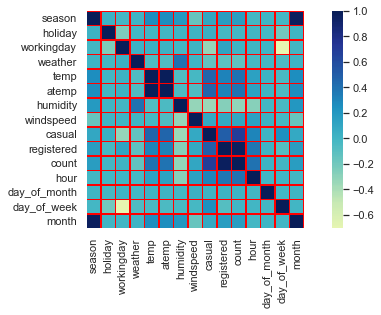

In [74]:
plt.figure(figsize=(10,4))
sns.heatmap(data.corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0,linecolor="red")

<AxesSubplot:ylabel='datetime'>

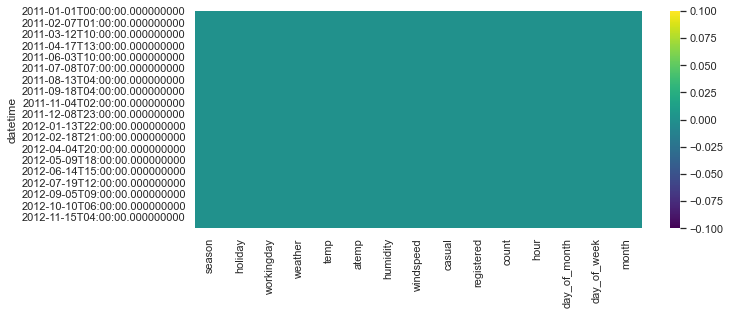

In [75]:
plt.figure(figsize=(10,4))
data.isnull().sum()
sns.heatmap(data.isnull(),cmap="viridis")

In [76]:
data["count"]

datetime
2011-01-01 00:00:00     16.0
2011-01-01 01:00:00     40.0
2011-01-01 02:00:00     32.0
2011-01-01 03:00:00     13.0
2011-01-01 04:00:00      1.0
                       ...  
2012-12-19 19:00:00    336.0
2012-12-19 20:00:00    241.0
2012-12-19 21:00:00    168.0
2012-12-19 22:00:00    129.0
2012-12-19 23:00:00     88.0
Name: count, Length: 10886, dtype: float64

(array([14975., 15065., 15156., 15248., 15340., 15431., 15522., 15614.,
        15706.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

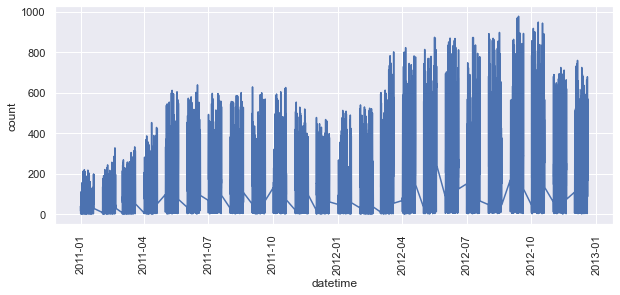

In [77]:
plt.figure(figsize=(10,4))
sns.lineplot(data=data,x=data.index,y=data["count"])
plt.xticks(rotation=90)

In [78]:
df_by_month = data.resample("M").sum()
df_by_month.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_month,day_of_week,month
datetime,,,,,,,,,,,,,,,
2011-01-31,431,24,264,621,3721.16,4641.000,24269,5926.1768,2008.0,21544.0,23552.0,5135,4235,1304,431
2011-02-28,446,0,327,615,5053.66,6243.965,23897,6917.1470,3776.0,29068.0,32844.0,5208,4467,1338,892
2011-03-31,446,0,328,654,6272.18,7535.435,24942,7151.1043,7910.0,30825.0,38735.0,5211,4440,1339,1338
2011-04-30,910,24,287,737,8088.48,9664.125,30160,7209.1263,12229.0,38288.0,50517.0,5241,4549,1392,1820
2011-05-31,912,0,336,697,9817.04,11607.545,32568,5634.0434,15865.0,63848.0,79713.0,5244,4560,1296,2280


(array([14975., 15065., 15156., 15248., 15340., 15431., 15522., 15614.,
        15706.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

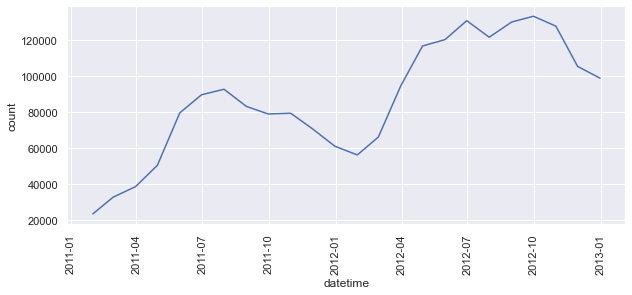

In [79]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df_by_month,x=df_by_month.index,y=df_by_month["count"])
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='count'>

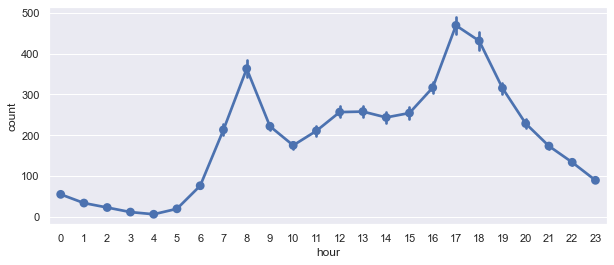

In [80]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.hour,y=data["count"])

<AxesSubplot:xlabel='month', ylabel='count'>

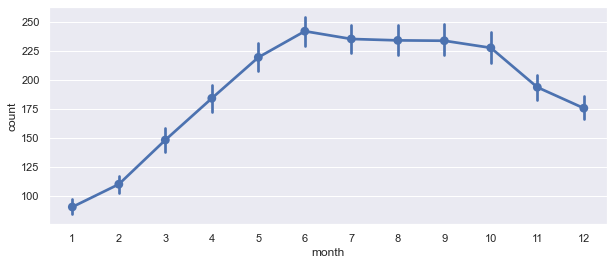

In [81]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.month,y=data["count"])

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

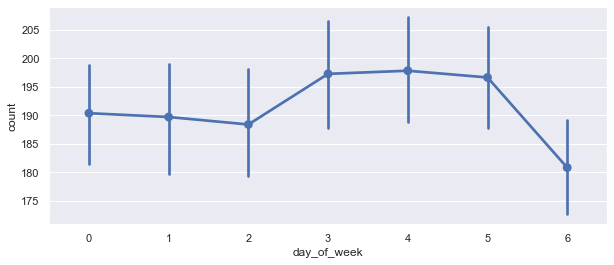

In [82]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.day_of_week,y=data["count"])

<AxesSubplot:xlabel='day_of_month', ylabel='count'>

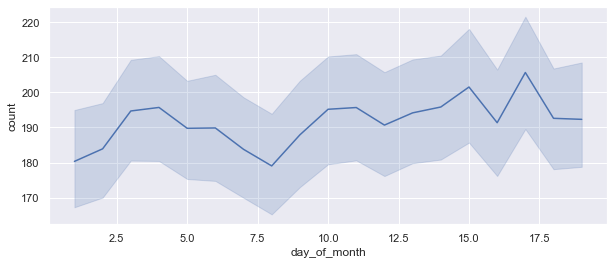

In [83]:
plt.figure(figsize=(10,4))
sns.lineplot(data=data,x=data.day_of_month,y=data["count"])

<AxesSubplot:xlabel='hour', ylabel='count'>

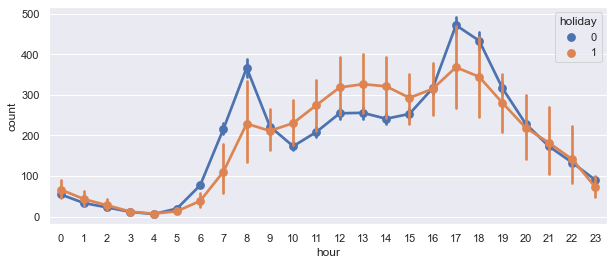

In [84]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.hour,y=data["count"],hue=data.holiday)

<AxesSubplot:xlabel='month', ylabel='count'>

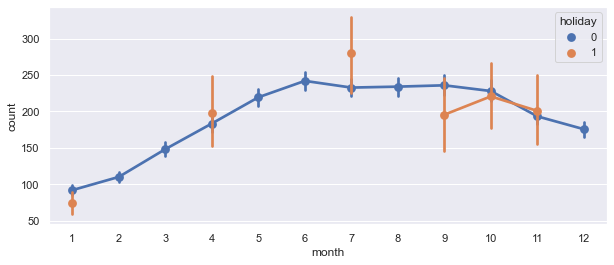

In [85]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.month,y=data["count"],hue=data.holiday)

<AxesSubplot:xlabel='month', ylabel='count'>

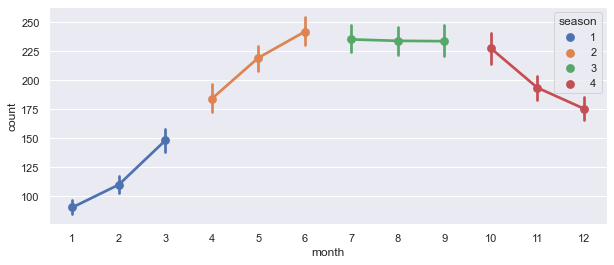

In [86]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,hue=data.season,y=data["count"],x=data.month)

<AxesSubplot:xlabel='season', ylabel='count'>

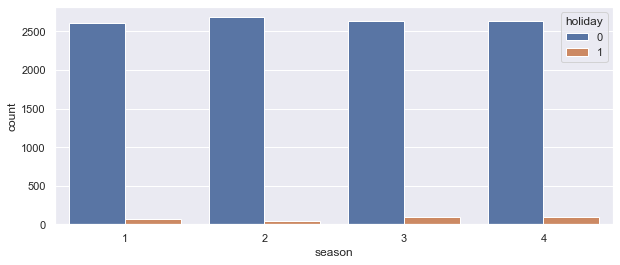

In [87]:
plt.figure(figsize=(10,4))
sns.countplot(data=data,hue=data.holiday,x=data.season)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]),
 [Text(0, 0, '0'),
  Text(1, 0, '8'),
  Text(2, 0, '10'),
  Text(3, 0, '12'),
  Text(4, 0, '13'),
  Text(5, 0, '14'),
  Text(6, 0, '15'),
  Text(7, 0, '16'),
  Text(8, 0, '17'),
  Text(9, 0, '18'),
  Text(10, 0, '19'),
  Text(11, 0, '20'),
  Text(12, 0, '21'),
  Text(13, 0, '22'),
  Text(14, 0, '23'),
  Text(15, 0, '24'),
  Text(16, 0, '25'),
  Text(17, 0, '26'),
  Text(18, 0, '27'),
  Text(19, 0, '28'),
  Text(20, 0, '29'),
  Text(21, 0, '30'),
  Text(22, 0, '31'),
  Text(23, 0, '32'),
  Text(24, 0, '33'),
  Text(25, 0, '34'),
  Text(26, 0, '35'),
  Text(27, 0, '36'),
  Text(28, 0, '37'

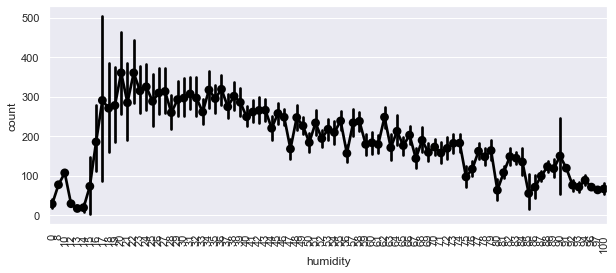

In [88]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.humidity,y=data["count"],color="black")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '6.0032'),
  Text(2, 0, '7.0015'),
  Text(3, 0, '8.9981'),
  Text(4, 0, '11.0014'),
  Text(5, 0, '12.998'),
  Text(6, 0, '15.0013'),
  Text(7, 0, '16.9979'),
  Text(8, 0, '19.0012'),
  Text(9, 0, '19.9995'),
  Text(10, 0, '22.0028'),
  Text(11, 0, '23.9994'),
  Text(12, 0, '26.0027'),
  Text(13, 0, '27.9993'),
  Text(14, 0, '30.0026'),
  Text(15, 0, '31.0009'),
  Text(16, 0, '32.9975'),
  Text(17, 0, '35.0008'),
  Text(18, 0, '36.9974'),
  Text(19, 0, '39.0007'),
  Text(20, 0, '40.9973'),
  Text(21, 0, '43.0006'),
  Text(22, 0, '43.9989'),
  Text(23, 0, '46.0022'),
  Text(24, 0, '47.9988'),
  Text(25, 0, '50.0021'),
  Text(26, 0, '51.9987'),
  Text(27, 0, '56.9969')])

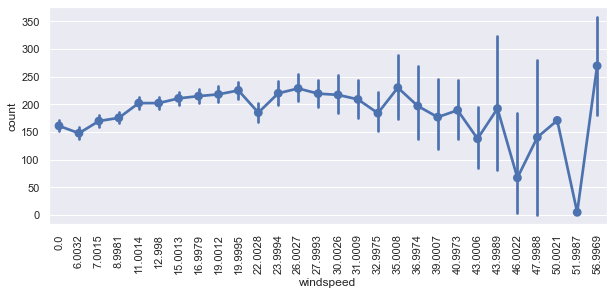

In [89]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.windspeed,y=data["count"])
plt.xticks(rotation=90)

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

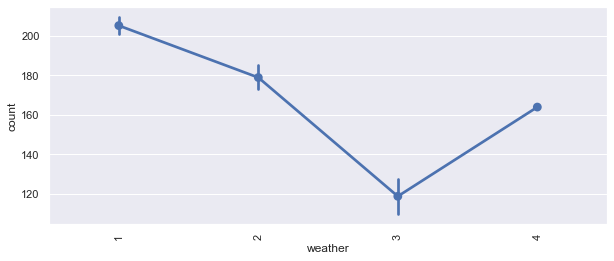

In [90]:
plt.figure(figsize=(10,4))
sns.pointplot(data=data,x=data.weather,y=data["count"])
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='count'>

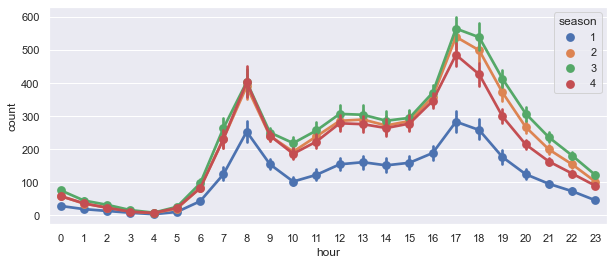

In [91]:
plt.figure(figsize=(10,4))
sns.pointplot(x=data.hour,y=data["count"],data=data,hue=data.season)

<AxesSubplot:xlabel='hour', ylabel='count'>

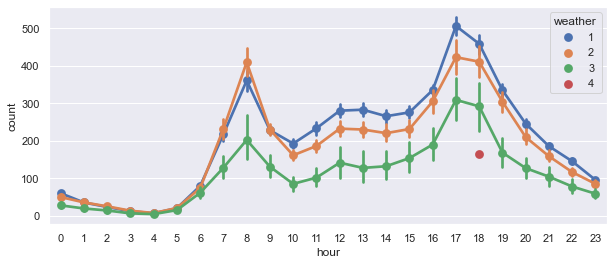

In [92]:
plt.figure(figsize=(10,4))
sns.pointplot(x=data.hour,y=data["count"],data=data,hue=data.weather)

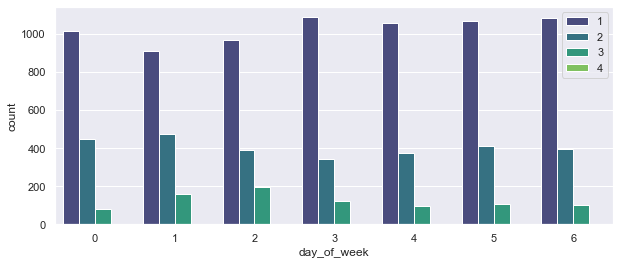

In [93]:
plt.figure(figsize=(10,4))
sns.countplot(data=data,x=data.day_of_week,hue=data.weather,palette="viridis")
plt.legend(loc="best")

<AxesSubplot:xlabel='hour', ylabel='count'>

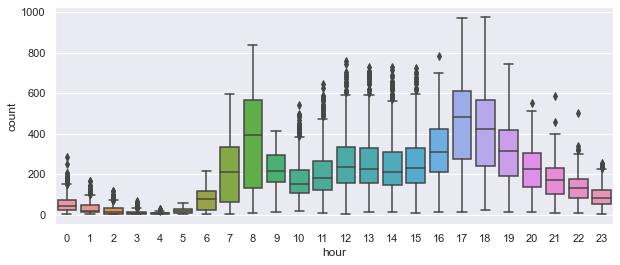

In [94]:
plt.figure(figsize=(10,4))
sns.boxplot(data=data,x=data["hour"],y=data["count"])

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

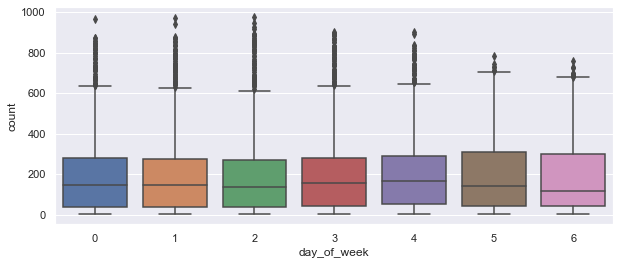

In [95]:
plt.figure(figsize=(10,4))
sns.boxplot(data=data,x=data["day_of_week"],y=data["count"])

<AxesSubplot:xlabel='day_of_month', ylabel='count'>

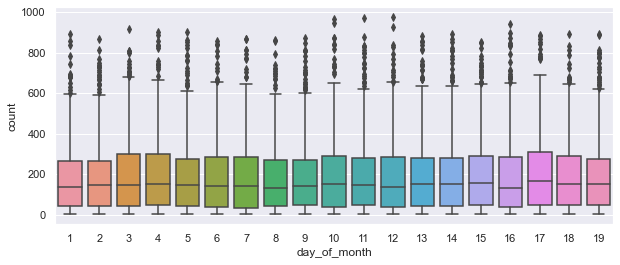

In [96]:
plt.figure(figsize=(10,4))
sns.boxplot(data=data,x=data["day_of_month"],y=data["count"])

<AxesSubplot:xlabel='month', ylabel='count'>

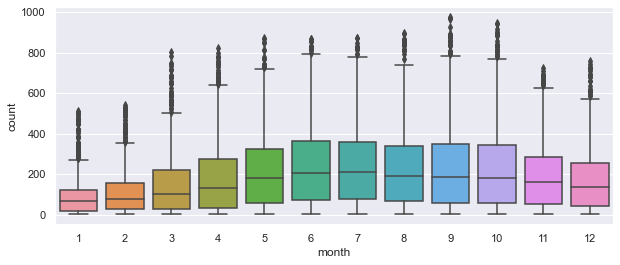

In [97]:
plt.figure(figsize=(10,4))
sns.boxplot(data=data,x=data["month"],y=data["count"])

<AxesSubplot:xlabel='day_of_month', ylabel='count'>

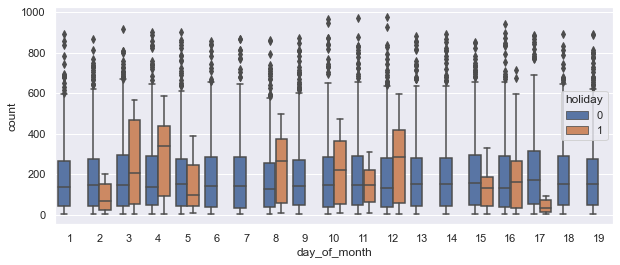

In [98]:
plt.figure(figsize=(10,4))
sns.boxplot(data=data,x=data["day_of_month"],y=data["count"],hue=data["holiday"])

In [99]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size=0.1,random_state=0)

print(train.shape)
print(test.shape)

(9797, 15)
(1089, 15)


In [100]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()

num_colu = ['temp', 'atemp', 'humidity', 'windspeed']

trans_1 = scaler.fit(train[num_colu].to_numpy())

In [101]:
tmp_train = pd.DataFrame(trans_1.transform(train[num_colu].to_numpy()), columns=num_colu)
tmp_train.index = train.index
tmp_test = pd.DataFrame(trans_1.transform(test[num_colu].to_numpy()), columns=num_colu)
tmp_test.index = test.index
tmp_train.head()

,temp,atemp,humidity,windspeed
datetime,,,,
2011-11-07 23:00:00,0.346939,0.379267,0.87,0.105325
2011-10-17 09:00:00,0.489796,0.517183,0.45,0.333373
2012-01-12 21:00:00,0.428571,0.465521,0.67,0.157870
2012-04-15 02:00:00,0.530612,0.551775,0.56,0.122840
2012-03-13 04:00:00,0.448980,0.482704,0.82,0.228047


In [102]:
cnt_scaler = MinMaxScaler()
trans_2 = cnt_scaler.fit(train[["count"]])
tmp_train["count"] = trans_2.transform(train[["count"]])
tmp_test["count"] = trans_2.transform(test[["count"]])
tmp_train.head()

,temp,atemp,humidity,windspeed,count
datetime,,,,,
2011-11-07 23:00:00,0.346939,0.379267,0.87,0.105325,0.048156
2011-10-17 09:00:00,0.489796,0.517183,0.45,0.333373,0.210041
2012-01-12 21:00:00,0.428571,0.465521,0.67,0.157870,0.177254
2012-04-15 02:00:00,0.530612,0.551775,0.56,0.122840,0.074795
2012-03-13 04:00:00,0.448980,0.482704,0.82,0.228047,0.000000


In [103]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_month,day_of_week,month
datetime,,,,,,,,,,,,,,,
2011-11-07 23:00:00,4,0,1,1,14.76,18.180,87,6.0032,1.0,47.0,48.0,23,7,0,11
2011-10-17 09:00:00,4,0,1,2,20.50,24.240,45,19.0012,26.0,180.0,206.0,9,17,0,10
2012-01-12 21:00:00,1,0,1,1,18.04,21.970,67,8.9981,12.0,162.0,174.0,21,12,3,1
2012-04-15 02:00:00,2,0,0,2,22.14,25.760,56,7.0015,20.0,54.0,74.0,2,15,6,4
2012-03-13 04:00:00,1,0,1,2,18.86,22.725,82,12.9980,0.0,1.0,1.0,4,13,1,3


In [104]:
tmp_train.iloc[:,4:5].to_numpy()
train_df = train
test_df = test

In [105]:
train.iloc[:,4:8] = tmp_train.iloc[:,0:4]
test.iloc[:,4:8] = tmp_test.iloc[:,0:4]

C:\Users\Irene\anaconda3\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [106]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_month,day_of_week,month
datetime,,,,,,,,,,,,,,,
2011-11-07 23:00:00,4,0,1,1,0.346939,0.379267,0.87,0.105325,1.0,47.0,48.0,23,7,0,11
2011-10-17 09:00:00,4,0,1,2,0.489796,0.517183,0.45,0.333373,26.0,180.0,206.0,9,17,0,10
2012-01-12 21:00:00,1,0,1,1,0.428571,0.465521,0.67,0.157870,12.0,162.0,174.0,21,12,3,1
2012-04-15 02:00:00,2,0,0,2,0.530612,0.551775,0.56,0.122840,20.0,54.0,74.0,2,15,6,4
2012-03-13 04:00:00,1,0,1,2,0.448980,0.482704,0.82,0.228047,0.0,1.0,1.0,4,13,1,3


In [107]:
train.iloc[:,10:11] = tmp_train.iloc[:,4:5].to_numpy()
test.iloc[:,10:11] = tmp_test.iloc[:,4:5].to_numpy()
train.head()

C:\Users\Irene\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_month,day_of_week,month
datetime,,,,,,,,,,,,,,,
2011-11-07 23:00:00,4,0,1,1,0.346939,0.379267,0.87,0.105325,1.0,47.0,0.048156,23,7,0,11
2011-10-17 09:00:00,4,0,1,2,0.489796,0.517183,0.45,0.333373,26.0,180.0,0.210041,9,17,0,10
2012-01-12 21:00:00,1,0,1,1,0.428571,0.465521,0.67,0.157870,12.0,162.0,0.177254,21,12,3,1
2012-04-15 02:00:00,2,0,0,2,0.530612,0.551775,0.56,0.122840,20.0,54.0,0.074795,2,15,6,4
2012-03-13 04:00:00,1,0,1,2,0.448980,0.482704,0.82,0.228047,0.0,1.0,0.000000,4,13,1,3


In [108]:
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
def prepare_data(X,y,time_steps=1):
    Xs = []
    Ys = []
    for i in tqdm(range(len(X) - time_steps)):
        a = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(a)
        Ys.append(y.iloc[i+time_steps])
    return np.array(Xs),np.array(Ys)    

steps=24
X_train , y_train = prepare_data(train,train["count"],time_steps=steps)
X_test , y_test = prepare_data(test,test["count"],time_steps=steps)
print("X_train : {}\nX_test : {}\ny_train : {}\ny_test: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

<ipython-input-108-b8cae77b644d>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


C:\Users\Irene\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
<ipython-input-108-b8cae77b644d>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(X) - time_steps)):



X_train : (9773, 24, 15)
X_test : (1065, 24, 15)
y_train : (9773,)
y_test: (1065,)


In [109]:
y_test

array([0.0307377 , 0.10758197, 0.04918033, ..., 0.        , 0.03893443,
       0.18647541])

In [110]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [111]:
#Time series generator
from keras.preprocessing.sequence import TimeseriesGenerator
#define generator 
n_input = len(y_train)
n_features = 15
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input, batch_size = 10)
#Note: both the parameters of TimeseriesGenerator are scaled_train #because to generate the data and the label it will use scaled_train

In [112]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model

model = Sequential()
model.add(LSTM(120,activation= "sigmoid" , input_shape = (n_input , n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam" , loss="mse")

model.fit_generator(generator , epochs=35)

C:\Users\Irene\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
3/3 [==============================] - 11s 3s/step - loss: 0.1436
Epoch 2/35
3/3 [==============================] - 11s 4s/step - loss: 0.1268
Epoch 3/35
3/3 [==============================] - 11s 4s/step - loss: 0.1253
Epoch 4/35
3/3 [==============================] - 11s 3s/step - loss: 0.1175
Epoch 5/35
3/3 [==============================] - 10s 3s/step - loss: 0.1251
Epoch 6/35
3/3 [==============================] - 10s 3s/step - loss: 0.1189
Epoch 7/35
3/3 [==============================] - 10s 3s/step - loss: 0.1143
Epoch 8/35
3/3 [==============================] - 11s 4s/step - loss: 0.1173
Epoch 9/35
3/3 [==============================] - 11s 3s/step - loss: 0.1104
Epoch 10/35
3/3 [==============================] - 10s 4s/step - loss: 0.1138
Epoch 11/35
3/3 [==============================] - 11s 4s/step - loss: 0.1094
Epoch 12/35
3/3 [==============================] - 9s 3s/step - loss: 0.1147
Epoch 13/35
3/3 [==============================] - 11s 3s/step - loss: 0.1

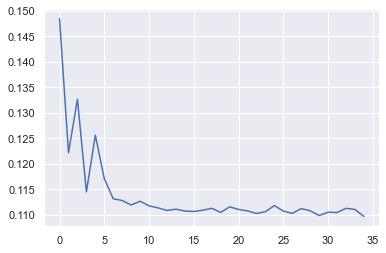

In [113]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [114]:
pred = model.predict(X_test)
np.shape(pred)

(1065, 1)

In [121]:
predicted = pd.DataFrame(pred)
predicted.columns =['predicted'] 
actual = pd.DataFrame(y_test)
actual.columns = ['actual']

In [122]:
final = pd.concat([actual,predicted],axis=1)
final.head()

,actual,predicted
0,0.030738,0.162827
1,0.107582,0.390434
2,0.049180,0.277758
3,0.296107,0.253842
4,0.150615,0.191998


In [123]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(final.actual,final.predicted)) 
r2 = r2_score(final.actual,final.predicted) 
print("rmse is : {}\nr2 is : {}".format(rmse,r2))

rmse is : 0.2212449334298849
r2 is : -0.3829914596608537


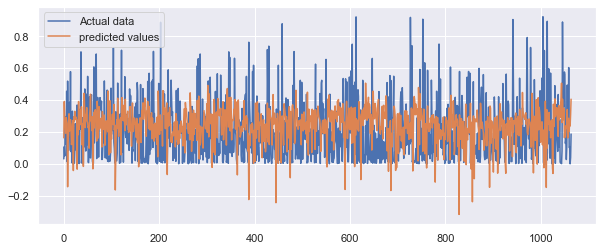

In [124]:
plt.figure(figsize=(10,4))
plt.plot(final.actual,label="Actual data")
plt.plot(final.predicted,label="predicted values")
plt.legend(loc="best")

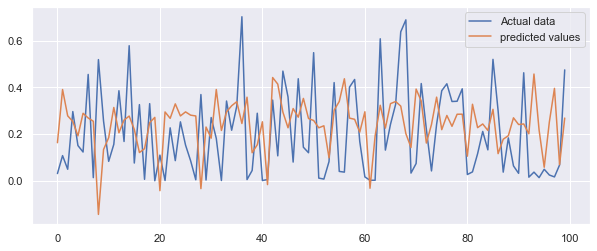

In [126]:
plt.figure(figsize=(10,4))
plt.plot(final.actual[0:100],label="Actual data")
plt.plot(final.predicted[0:100],label="predicted values")
plt.legend(loc="best")